## Adjust SMA windows 


In [17]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [18]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [19]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


In [20]:
# Set the short window and long window
short_window = 5
long_window = 50

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-02-23 15:30:00,24.46,0.000818,24.468,24.2200
2015-02-23 15:45:00,24.49,0.001226,24.466,24.2302
2015-02-24 10:45:00,24.72,0.009392,24.510,24.2362
2015-02-24 11:00:00,24.74,0.000809,24.570,24.2422
2015-02-24 12:15:00,24.70,-0.001617,24.622,24.2470


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.192,31.2232
2021-01-22 11:30:00,33.35,0.002405,33.232,31.2848
2021-01-22 13:45:00,33.42,0.002099,33.302,31.3480
2021-01-22 14:30:00,33.47,0.001496,33.402,31.4132
2021-01-22 15:45:00,33.44,-0.000896,33.390,31.4768


In [21]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-02-23 15:30:00,24.46,0.000818,24.468,24.2200,1.0
2015-02-23 15:45:00,24.49,0.001226,24.466,24.2302,1.0
2015-02-24 10:45:00,24.72,0.009392,24.510,24.2362,1.0
2015-02-24 11:00:00,24.74,0.000809,24.570,24.2422,1.0
2015-02-24 12:15:00,24.70,-0.001617,24.622,24.2470,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.192,31.2232,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.232,31.2848,1.0
2021-01-22 13:45:00,33.42,0.002099,33.302,31.3480,1.0
2021-01-22 14:30:00,33.47,0.001496,33.402,31.4132,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.390,31.4768,-1.0


In [22]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-02-23 15:30:00,24.46,0.000818,24.468,24.2200,1.0,NaN
2015-02-23 15:45:00,24.49,0.001226,24.466,24.2302,1.0,0.001226
2015-02-24 10:45:00,24.72,0.009392,24.510,24.2362,1.0,0.009392
2015-02-24 11:00:00,24.74,0.000809,24.570,24.2422,1.0,0.000809
2015-02-24 12:15:00,24.70,-0.001617,24.622,24.2470,-1.0,-0.001617


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.192,31.2232,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.232,31.2848,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.302,31.3480,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.402,31.4132,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.390,31.4768,-1.0,-0.000896


In [23]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,24.468,24.2200
2015-02-24 10:45:00,24.466,24.2302
2015-02-24 11:00:00,24.510,24.2362
2015-02-24 12:15:00,24.570,24.2422
2015-02-24 15:45:00,24.622,24.2470


In [24]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']


In [25]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 6 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2015-02-23 15:45:00
2015-08-23 15:45:00


In [26]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,24.468,24.2200
2015-02-24 10:45:00,24.466,24.2302
2015-02-24 11:00:00,24.510,24.2362
2015-02-24 12:15:00,24.570,24.2422
2015-02-24 15:45:00,24.622,24.2470


In [27]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,24.468,24.2200
2015-02-24 10:45:00,24.466,24.2302
2015-02-24 11:00:00,24.510,24.2362
2015-02-24 12:15:00,24.570,24.2422
2015-02-24 15:45:00,24.622,24.2470


In [28]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [29]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      0.00      0.00      1757
         1.0       0.56      1.00      0.72      2244

    accuracy                           0.56      4001
   macro avg       0.78      0.50      0.36      4001
weighted avg       0.75      0.56      0.40      4001



In [31]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(index=X_test.index)

# Create a predictions DataFrame
#predictions_df = # YOUR CODE HERE

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Actual Returns"] * svm_pred

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-08-25 10:45:00,1.0,-0.000482,-0.000482
2015-08-25 13:15:00,1.0,-0.001928,-0.001928
2015-08-25 15:00:00,1.0,-0.006277,-0.006277
2015-08-25 15:45:00,1.0,-0.014091,-0.014091
2015-08-27 09:45:00,1.0,0.046328,0.046328


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


<AxesSubplot:xlabel='date'>

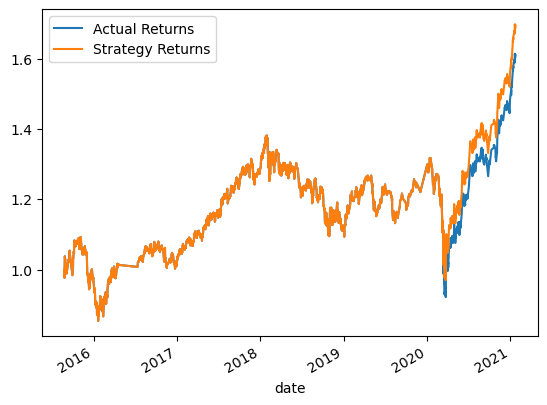

In [32]:
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()